In [224]:
import os
import torch
from torch import nn
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [225]:
def train_loop(dataloader, model, loss_fn = nn.CrossEntropyLoss()):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        with torch.no_grad():
            pred = model.forward(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            model.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [226]:
train_set = datasets.MNIST("data", download=True, train=True, transform=ToTensor())
test_set = datasets.MNIST("data", download=True, train=False, transform=ToTensor())
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [227]:
def dSigmoid(a):
    return a * torch.sub(1, a)

In [241]:
class BillNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.W1 = nn.Linear(28 * 28, 300, bias=False)
        self.W2 = nn.Linear(300, 200, bias=False)
        self.W3 = nn.Linear(200, 10, bias=False)

        self.W1.weight = nn.Parameter(torch.zeros([300, 28 * 28]))
        self.W2.weight = nn.Parameter(torch.zeros([200, 300]))
        self.W3.weight = nn.Parameter(torch.zeros([10, 200]))

    def forward(self, x):
        x = self.flatten(x)
        self.z1 = f.linear(x, self.W1.weight)
        self.a1 = f.sigmoid(self.z1)
        self.z2 = f.linear(self.a1, self.W2.weight)
        self.a2 = f.sigmoid(self.z2)
        self.z3 = f.linear(self.a2, self.W3.weight)
        return f.softmax(self.z3, dim=1)

    def backward(self, X, Y, lr, batch):
        batchdW1, batchdW2, batchdW3 = 0, 0, 0
        for i in range(X.size()[0]):
            with torch.no_grad():
                y_pred = self.forward(X[i])

                x = self.flatten(X[i])
                y = f.one_hot(Y[i], num_classes=10).float()
                dz3 = y_pred - y
                dW3 = torch.mul(torch.transpose(dz3, 0, 1), self.a2)
                dz2 = torch.matmul(dz3, self.W3.weight) * dSigmoid(self.a2)
                dW2 = torch.mul(torch.transpose(dz2, 0, 1), self.a1)
                dz1 = torch.matmul(dz2, self.W2.weight) * dSigmoid(self.a1)
                dW1 = torch.mul(torch.transpose(dz1, 0, 1), x)

                batchdW1 += dW1
                batchdW2 += dW2
                batchdW3 += dW3

        self.W3.weight -= lr * batchdW3 / batch
        self.W2.weight -= lr * batchdW2 / batch
        self.W1.weight -= lr * batchdW1 / batch

In [242]:
model = BillNet()
loss_fn = nn.CrossEntropyLoss()
epochs = 10
for t in range(epochs):
    size = len(train_dataloader.dataset)
    print(f"Epoch {t+1}\n-------------------------------")
    for batch, (X, y) in enumerate(train_dataloader):
        with torch.no_grad():
            model.backward(X, y, 0.1, 64)

    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.6%, Avg loss: 2.302721 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.302241 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.302211 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301269 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.299514 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.277092 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.241993 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.230887 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.226548 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.224612 

Done!


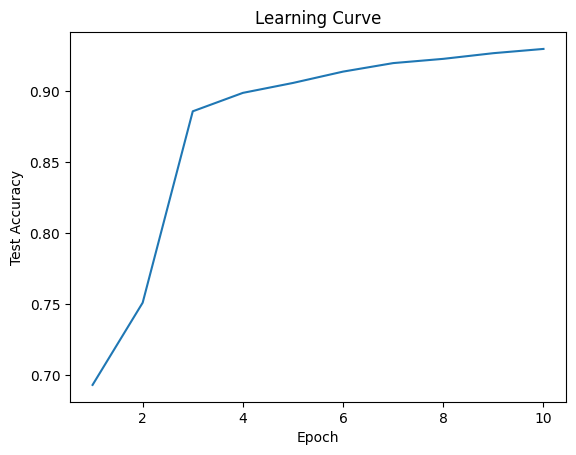

In [ ]:
plt.title('Learning Curve')
plt.plot(range(1, 11), [.693, .751, .886, .899, .906, .914, .92, .923, .927, .93])
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

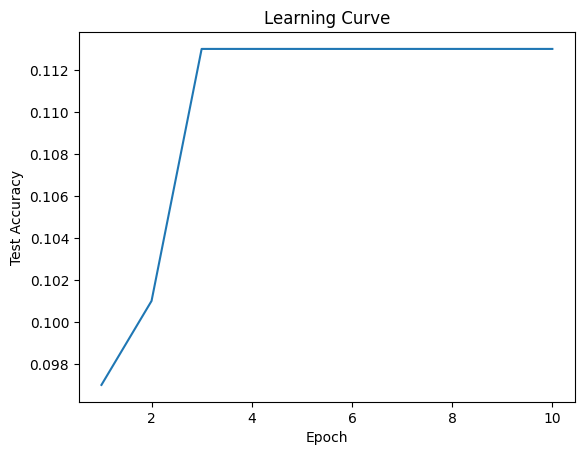

In [238]:
plt.title('Learning Curve')
plt.plot(range(1, 11), [.097, .101, .113, .113, .113, .113, .113, .113, .113, .113])
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
plt.title('Learning Curve')
plt.plot(range(1, 11), [.097, .101, .113, .113, .113, .113, .113, .113, .113, .113])
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.show()